In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
import fca_interp as fcai

In [3]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats],
                                                    bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]),
                                                   random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_feats)
test_pool = Pool(X_test, y_test, cat_features=cat_feats)
bb = CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

,metrics,train,test
0,accuracy_score,0.954572,0.902741
1,precision_score,0.932143,0.600000
2,recall_score,0.659091,0.360000
3,y_mean,0.116814,0.110522


In [5]:
total_bb_preds = bb.predict(bank_ds[cat_feats+real_feats])
total_bb_preds.mean()

0.0785224507852245

# Бинаризация данных

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.metrics import roc_auc_score

In [8]:
def delete_lower_neighbs(fm, c):
    lns = [fm.get_concept_by_id(ln_id) for ln_id in c._low_neighbs]
    for ln in lns:
        delete_lower_neighbs(fm, ln)
    fm.delete_concept(c._idx)

In [9]:
def delete_all_lower_neighbs_downwise(fm, min_y=0, max_y=1):
    idx = 0
    while len([c for c in fm._concepts if c._y_pred_mean is not None and 
               round(c._y_pred_mean,2) in [min_y,max_y] and len(c._low_neighbs)>0])>0:
        #print(idx)
        c = [c for c in fm._concepts if c._y_pred_mean is not None and 
             round(c._y_pred_mean,2) in [min_y,max_y] and len(c._low_neighbs)>0][0]
        delete_lower_neighbs(fm, fm.get_concept_by_id(list(c._low_neighbs)[0]))
        idx += 1    

In [10]:
def generate_bin_hyps(ds, cat_feats, real_feats, n_ts_real_feats=100):
    ds = bank_ds.copy()
    bin_ds = pd.DataFrame()
    for f in cat_feats:
        for v in ds[f].unique():
            bin_ds[f"{f}_is_{v}"] = (ds[f]==v).astype(int)
            bin_ds[f"{f}_not_{v}"] = (ds[f]!=v).astype(int)
    for f in real_feats:
        for t in np.random.choice(ds[f], size=n_ts_real_feats, replace=False):
            bin_ds[f"{f}_lt_{t}"] = (ds[f]<t).astype(int)
            bin_ds[f"{f}_geq_{t}"] = (ds[f]>=t).astype(int)
    return bin_ds

In [11]:
def test_feats(bin_ds, fs, y, n_estimators=100, metric=accuracy_score):
    rf = RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(bin_ds[fs], y)
    ac = metric(y, rf.predict(bin_ds[fs]))
    s = pd.Series(rf.feature_importances_, index=fs).sort_values(ascending=False)
    return ac, s

In [12]:
def squeeze_bin_dataset(bin_ds, y, metric=accuracy_score, metric_lim=1):
    fs = bin_ds.columns
    for i in tqdm(range(len(bin_ds.columns))):
        for f in fs[::-1]:
            fs_ = [f_ for f_ in fs if f_!=f]
            ac, s = test_feats(bin_ds, fs_, y, metric=metric)
            
            if ac>=metric_lim:
                fs = list(s.index)
                break
        else:
            break
    return fs

In [66]:
bin_ds = generate_bin_hyps(bank_ds, cat_feats, real_feats, n_ts_real_feats=5, )
print(bin_ds.shape)
bin_ds.head()

(4521, 142)


,job_is_unemployed,job_not_unemployed,job_is_services,job_not_services,job_is_management,job_not_management,job_is_blue-collar,job_not_blue-collar,job_is_self-employed,job_not_self-employed,...,campaign_lt_3,campaign_geq_3,pdays_lt_-1,pdays_geq_-1,pdays_lt_281,pdays_geq_281,previous_lt_0,previous_geq_0,previous_lt_1,previous_geq_1
0,1,0,0,1,0,1,0,1,0,1,...,1,0,0,1,1,0,0,1,1,0
1,0,1,1,0,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,0,1
2,0,1,0,1,1,0,0,1,0,1,...,1,0,0,1,0,1,0,1,0,1
3,0,1,0,1,1,0,0,1,0,1,...,0,1,0,1,1,0,0,1,1,0
4,0,1,0,1,0,1,1,0,0,1,...,1,0,0,1,1,0,0,1,1,0


In [78]:
ac, s = test_feats(bin_ds, bin_ds.columns, total_bb_preds,)
print(ac)

1.0


In [114]:
fs_short = squeeze_bin_dataset(bin_ds, total_bb_preds, metric_lim=0.95)
len(fs_short)

8

In [115]:
bin_ds[fs_short].drop_duplicates().T.drop_duplicates().T.shape

(96, 8)

In [126]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(bin_ds[fs_short], total_bb_preds)
roc_auc_score(total_bb_preds, rf.predict_proba(bin_ds[fs_short])[:,1])

0.9340354174977856

In [127]:
accuracy_score(total_bb_preds, rf.predict(bin_ds[fs_short]))

0.9500110595001106

In [118]:
fs_short

['poutcome_not_success',
 'duration_lt_968',
 'duration_lt_253',
 'month_not_oct',
 'previous_lt_1',
 'housing_is_yes',
 'marital_is_married',
 'balance_lt_1384']

In [119]:
bin_ds_short = bin_ds[fs_short]

In [120]:
bank_ds.shape[0]

4521

In [121]:
bin_ds_short.drop_duplicates().T.drop_duplicates().T.shape, bin_ds_short.drop_duplicates().T.drop_duplicates().T.shape[0]/bank_ds.shape[0]

((96, 8), 0.021234240212342402)

In [122]:
%%time
cntx_bank = fcai.Context(bin_ds_short.astype(bool),y_true=(bank_ds[y_feat]=='yes').astype(int), y_pred=total_bb_preds)
fm_bank = fcai.FormalManager(cntx_bank, ds_obj=None, task_type='binary classification')
fm_bank.construct_concepts(use_tqdm=False, is_monotonic=False)
print(len(fm_bank._concepts))

144
CPU times: user 1.25 s, sys: 3 µs, total: 1.25 s
Wall time: 1.25 s


In [123]:
fm_bank.construct_lattice(use_tqdm=False)

In [124]:
fig = fm_bank.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [125]:
fig.show()

In [129]:
new_obj_by_levels = {i:[] for i in range(fm_bank.get_concept_by_id(len(fm_bank._concepts)-1)._level+1)}
for c in fm_bank._concepts:
    new_obj_by_levels[c._level] += list(c._new_objs)

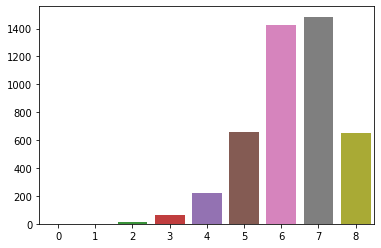

In [130]:
s = pd.Series({k:len(v) for k,v in new_obj_by_levels.items()})
sns.barplot(x=s.index, y=s.values)
plt.show()

In [131]:
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))

In [132]:
def get_stability(cidx, fm):
    stab = 0
    ext_ = fm.get_concept_by_id(cidx).get_extent()
    int_ = fm.get_concept_by_id(cidx).get_intent()
    cntx = fm.get_context()
    
    for s in powerset(ext_):
        stab += int(set(cntx.get_intent([str(g) for g in s if g in cntx._objs]))==set(int_))
    stab /= 2**(len(ext_))
    return stab

In [134]:
def get_stab_bounds(cidx, fm):
    c = fm.get_concept_by_id(cidx)
    lns = c._low_neighbs
    difs = np.array(sorted([len(set(c.get_extent())-set(fm.get_concept_by_id(didx).get_extent())) for didx in lns])).astype(float)
    minb = 1-sum(1/(2**difs))
    maxb = 1-1/(2**difs[0])
    return minb, maxb, difs[0]

In [135]:
%timeit get_stab_bounds(100, fm_bank)

2.71 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [143]:
for c in tqdm(fm_bank._concepts):
    if len(c._low_neighbs)>0:
        minb, maxb, mindif = get_stab_bounds(c._idx, fm_bank)
    elif len(c.get_extent())<10:
        print('calc real stability for idx', c._idx)
        minb = get_stability(c._idx, fm_bank)
        maxb = minb
        mindif = None
    else:
        #raise ValueError(f'Too big extent to calc pure stability ({c._idx} concept)')
        print((f'Too big extent to calc pure stability ({c._idx} concept)'))
        minb, maxb, mindif = [None]*3
    c._metrics['stab_min_bound'] = minb
    c._metrics['stab_max_bound'] = maxb
    c._metrics['log_stab_min_bound'] = -np.log2(1-minb) if minb is not None else None
    c._metrics['log_stab_max_bound'] = -np.log2(1-maxb) if maxb is not None else None
    c._metrics['lstab_min_bound'] = mindif-len(fm_bank.get_context()._attrs_full) if mindif is not None else None

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

divide by zero encountered in log2

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in log2

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in power



Too big extent to calc pure stability (143 concept)



In [144]:
n_nonstab_concepts = len([c for c in fm_bank._concepts if  not(c._metrics['lstab_min_bound'] is not None and c._metrics['lstab_min_bound']>=5)])
n_nonstab_concepts, n_nonstab_concepts/len(fm_bank._concepts)

(37, 0.2569444444444444)

In [145]:
stable_concepts = [c for c in fm_bank._concepts if  c._metrics['lstab_min_bound'] is not None and c._metrics['lstab_min_bound']>=5]
len(stable_concepts)

107

In [146]:
from copy import copy

In [147]:
fm_bank_stab = fcai.FormalManager(cntx_bank, ds_obj=None, task_type='binary classification')
fm_bank_stab._concepts = stable_concepts
for idx, c in enumerate(sorted(fm_bank_stab._concepts, key=lambda c: (len(c.get_intent()), ','.join(c.get_intent())))):
    c._idx = idx
fm_bank_stab.construct_lattice()

In [148]:
fig_stab = fm_bank_stab.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='lstab_min_bound',)

In [149]:
fig_stab.show()

In [150]:
def get_prediction_by_concepts(concepts):
    objects_preds = {}
    for c in sorted(concepts, key=lambda c: -c._idx):
        for g in c.get_extent():
            if g not in objects_preds:
                objects_preds[g] = c._y_pred_mean    
    return pd.Series(objects_preds)

In [151]:
len(fm_bank._concepts), len(fm_bank_stab._concepts)

(144, 107)

In [152]:
s = get_prediction_by_concepts(fm_bank._concepts)
s.index = s.index.astype(int)
s = s.sort_index()
roc_auc_score(total_bb_preds, s.values)

0.8880785432711487

In [153]:
s = get_prediction_by_concepts(fm_bank_stab._concepts)
s.index = s.index.astype(int)
s = s.sort_index()
roc_auc_score(total_bb_preds, s.values)

0.8942881001805358

In [154]:
def get_bottom_concepts_ids(concepts):
    objects_concepts = {}
    for c in sorted(concepts, key=lambda c: -c._idx):
        if c._idx==0:
            continue
        for g in c.get_extent():
            if g not in objects_concepts.keys():
                objects_concepts[g] = c._idx
    return sorted(set(objects_concepts.values()))

In [155]:
len(get_bottom_concepts_ids(fm_bank._concepts)), len(get_bottom_concepts_ids(fm_bank_stab._concepts))

(85, 82)

In [156]:
base_roc = get_prediction_by_concepts(fm_bank._concepts)
base_roc.index = base_roc.index.astype(int)
base_roc = base_roc.sort_index()
base_roc = roc_auc_score(total_bb_preds, base_roc)
base_roc

0.8880785432711487

In [157]:
def select_best_roc_concepts(concepts, y):
    base_roc = get_prediction_by_concepts(concepts)
    base_roc.index = base_roc.index.astype(int)
    base_roc = base_roc.sort_index()
    base_roc = roc_auc_score(y, base_roc)
    
    cur_base_roc = base_roc
    dropped_concepts = set()
    roc_hystory = []
    for i in tqdm(range(len(concepts))):
        new_rocs = {}

        bottom_concepts_ids = get_bottom_concepts_ids([c for c in concepts if c._idx not in dropped_concepts])

        for cidx in tqdm([cidx for cidx in bottom_concepts_ids], leave=False):
            s = get_prediction_by_concepts([c for c in concepts if c._idx!=cidx and c._idx not in dropped_concepts])
            s.index = s.index.astype(int)
            s = s.sort_index()
            new_rocs[cidx] = roc_auc_score(y, s.values)
        new_rocs = pd.Series(new_rocs)

        if new_rocs.max()<cur_base_roc:
            break

        cur_base_roc = new_rocs.max()
        roc_hystory.append(cur_base_roc)
        dropped_concepts.add(new_rocs.idxmax())
    return [c for c in concepts if c._idx not in dropped_concepts], [base_roc]+roc_hystory, dropped_concepts

In [158]:
best_roc_concepts, roc_hystory, dc = select_best_roc_concepts(sorted(fm_bank._concepts, key=lambda c:c._idx), total_bb_preds)

In [173]:
roc_hystory[0], roc_hystory[-1]

(0.8880785432711487, 0.9205499922241079)

In [159]:
best_roc_concepts_stab, roc_hystory_stab, dc = select_best_roc_concepts(sorted(fm_bank_stab._concepts, key=lambda c:c._idx), total_bb_preds)

In [174]:
roc_hystory_stab[0], roc_hystory_stab[-1]

(0.8942881001805358, 0.9256242688971081)

In [160]:
len(best_roc_concepts), len(best_roc_concepts_stab)

(72, 59)

In [161]:
len(best_roc_concepts)/len(fm_bank._concepts), len(best_roc_concepts_stab)/len(fm_bank_stab._concepts)

(0.5, 0.5514018691588785)

In [169]:
base_roc_rf = roc_auc_score(total_bb_preds, rf.predict_proba(bin_ds_short)[:,1])
base_roc_rf

0.9340354174977856

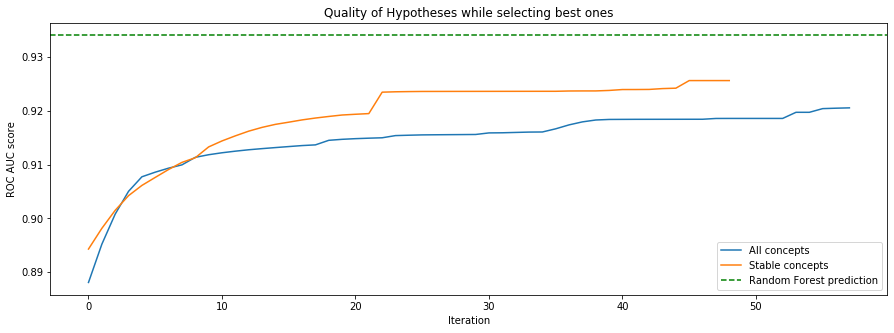

In [172]:
plt.figure(figsize=(15,5))
plt.plot(roc_hystory, label='All concepts')
plt.plot(roc_hystory_stab, label='Stable concepts')
plt.axhline(base_roc_rf, label='Random Forest prediction', linestyle='--', color='green')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ROC AUC score')
plt.title('Quality of Hypotheses while selecting best ones')
plt.show()